### <center> This notebook has the postprocess of raw Level 3 ASCAT/QuikSCAT data and the following construction of a surface wind dataset for the tropical band and the coastal bands of the south east and north east pacific.


The data used will be the full global grid of the ASCAT/QuikSCAT dataset. The idea is to load the data into chunks and then extract only the tropical band and the whole east pacific. With that data on hand a hovmoller will be built from the meridional average of the tropical dataset and the zonal average of the coastal dataset. The variables to be used will be the meridional and zonal componentes of the 10 meter winds (not the stress, since S2S gives only 10m wind forecast). In addition for the coastal bands the alongshore wind will be computed using the land/sea mask. 

In [1]:
# Imports
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

# Just for supressing an annoying warning
import dask
dask.config.set({"array.slicing.split_large_chunks": False})

In [2]:
# Load ASCAT/QuikSCAT masks
mask = xr.open_dataset('data/ASCAT_masks.nc')

In [6]:
# Load scatterometer data

# ASCAT
path = [glob(f'data/ASCAT/{yr}*') for yr in range(2008,2023+1)]
path = sorted(sum(path,[]))

def preprocess(data):
    print(data.time.dt.strftime('%F').data)
    data = data.rename({'latitude':'lat','longitude':'lon'}).squeeze().drop('depth')
    data = data[['wind_stress',
                 'surface_downward_eastward_stress',
                 'surface_downward_northward_stress']]
    data = data.rename({'wind_stress':'tau',
                 'surface_downward_eastward_stress':'taux',
                 'surface_downward_northward_stress':'tauy'})
    data = data.sel(lat=slice(-45,45))
    data.coords['lon'] = xr.where(data.lon<0,data.lon+360,data.lon)
    data = data.sortby('lon').sel(lon=slice(110,291))
    return data.compute()

scat = xr.open_mfdataset(path, preprocess=preprocess, parallel=True, concat_dim='time', combine='nested')

['2009-08-31']
['2013-12-18']
['2022-09-30']
['2016-12-23']
['2022-07-26']
['2017-01-26']
['2015-01-09']
['2013-08-09']
['2009-07-20']
['2013-10-06']
['2011-10-02']
['2014-06-02']
['2016-06-16']
['2012-06-29']
['2008-11-27']
['2008-11-21']
['2012-09-08']
['2008-02-16']
['2011-09-03']
['2022-11-21']
['2022-08-29']
['2012-07-27']
['2019-06-13']
['2014-11-24']
['2021-10-23']
['2019-09-05']
['2021-09-02']
['2015-06-18']
['2015-04-06']
['2016-08-09']
['2021-07-25']
['2015-06-15']
['2009-05-05']
['2011-12-03']
['2013-01-26']
['2016-05-16']
['2014-06-17']['2008-06-14']

['2017-11-07']
['2021-02-08']
['2017-12-31']
['2011-02-17']
['2019-02-28']
['2021-05-27']
['2015-09-08']
['2021-12-18']
['2018-02-22']
['2020-10-19']
['2014-07-13']
['2014-01-05']
['2008-07-13']
['2012-09-03']
['2017-10-31']
['2013-09-10']
['2018-10-14']
['2011-03-04']
['2018-04-15']
['2016-11-28']
['2010-10-31']
['2018-02-12']
['2013-12-26']
['2021-07-22']
['2013-07-27']
['2009-05-29']
['2015-08-02']
['2019-02-16']
['2023-04-

In [84]:
scat

<xarray.Dataset>
Dimensions:  (time: 5568, lat: 360, lon: 724)
Coordinates:
  * time     (time) datetime64[ns] 2008-01-01T12:00:00 ... 2023-05-21T12:00:00
  * lat      (lat) float32 -44.88 -44.62 -44.38 -44.12 ... 44.38 44.62 44.88
  * lon      (lon) float32 110.1 110.4 110.6 110.9 ... 290.1 290.4 290.6 290.9
Data variables:
    tau      (time, lat, lon) float32 0.0929 0.0991 0.0801 ... nan nan nan
    taux     (time, lat, lon) float32 0.0736 0.0792 0.0601 ... nan nan nan
    tauy     (time, lat, lon) float32 -0.0567 -0.0596 -0.0529 ... nan nan nan
Attributes: (12/22)
    Conventions:              CF-1.4
    title:                    Daily ASCAT global wind field
    references:               Bentamy, A.; Croize-Fillon, 2010: Gridded surfa...
    institution:              ifremer
    source:                   produced at 2011-05-20
    bulletin_date:            2011-05-20
    ...                       ...
    grid_resolution:          0.250 degree
    file_quality_index:       0.0
    time_resolution:          daily
    objective_method:         krigeage
    polar_sea_ice_mask_date:  2008-01-01
    creation_date_time:       20110520T225509

---

##### Tropical hovmoller

In [120]:
# Build tropical hovmoller
tropical = scat.sel(lat=slice(-3,3),lon=slice(mask.lon.min(),mask.lon.max()))
tropical = tropical.where(mask.tropicalmask==1).mean('lat')
tropical = tropical.interpolate_na('lon')  # Inteprolate 180°E nans
tropical = tropical.interpolate_na('time') # Fill missing fields with interpolation of inbetween fields
tropical = tropical.dropna('lon') # Drop all land nans
tropical

<xarray.Dataset>
Dimensions:  (time: 5568, lon: 566)
Coordinates:
  * time     (time) datetime64[ns] 2008-01-01T12:00:00 ... 2023-05-21T12:00:00
  * lon      (lon) float32 140.1 140.4 140.6 140.9 ... 280.6 280.9 281.1 281.4
Data variables:
    tau      (time, lon) float32 0.1312 0.1263 0.1243 ... 0.04217 0.0604 0.0817
    taux     (time, lon) float32 0.1186 0.1114 0.1053 ... 0.02917 0.0473 0.0655
    tauy     (time, lon) float32 -0.05094 -0.05077 -0.0512 ... 0.0376 0.0488

---

##### Build coastal hovmollers

In [121]:
# north
coastnorth = scat.sel(lon=slice(230,295), lat=slice(0,50))
coastnorth = coastnorth.where(mask.coastmask_north==1).mean('lon')
coastnorth = coastnorth.interpolate_na('time').dropna('lat')
coastnorth

<xarray.Dataset>
Dimensions:  (lat: 152, time: 5568)
Coordinates:
  * lat      (lat) float64 2.125 2.375 2.625 2.875 ... 39.12 39.38 39.62 39.88
  * time     (time) datetime64[ns] 2008-01-01T12:00:00 ... 2023-05-21T12:00:00
Data variables:
    tau      (time, lat) float32 0.04032 0.0455 0.04947 ... 0.4027 0.388 0.3974
    taux     (time, lat) float32 0.03977 0.04532 0.0489 ... 0.1445 0.1385 0.1219
    tauy     (time, lat) float32 0.0044 0.0039 0.007475 ... -0.3619 -0.3768

In [122]:
# south
coastsouth = scat.sel(lon=slice(260,295), lat=slice(-50,0))
coastsouth = coastsouth.where(mask.coastmask_south==1).mean('lon')
coastsouth = coastsouth.interpolate_na('time').dropna('lat').sortby('lat', ascending=False)
coastsouth

<xarray.Dataset>
Dimensions:  (lat: 152, time: 5568)
Coordinates:
  * lat      (lat) float64 -2.125 -2.375 -2.625 -2.875 ... -39.38 -39.62 -39.88
  * time     (time) datetime64[ns] 2008-01-01T12:00:00 ... 2023-05-21T12:00:00
Data variables:
    tau      (time, lat) float32 0.02975 0.02962 0.02778 ... 0.1338 0.1222
    taux     (time, lat) float32 0.01765 0.0152 0.01325 ... 0.1152 0.1104
    tauy     (time, lat) float32 0.02342 0.02437 0.02358 ... -0.06688 -0.05213

---

##### Add coordinate and metadata

In [123]:
def haversine(p1,p2):
    """
    Given two points with lat,lon coordinates, compute the distance
    between those points on the surface of the sphere with the haversine formula
    Args:
        p1 (tuple): first point lat,lon
        p2 (tuple): last point lat,lon

    Returns:
        float: distance
    """
    lat1,lon1 = p1
    lat2,lon2 = p2

    lon1,lon2,lat1,lat2 = map(np.deg2rad, [lon1,lon2,lat1,lat2])

    dlon = lon2-lon1
    dlat = lat2-lat1

    a = np.sin(dlat/2)**2+np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2*np.arcsin(np.sqrt(a))
    r = 6371
    return c*r

def distances(data, lon_name='lon', lat_name='lat'):
    """
    This function uses the haversine formula to build a 
    distance vector based on the latitude and longitude
    of the hovmoller data contained in xarray format.
    Args:
        data (xarray.Dataset): 
        Data set with the coastal or coastnorth hovmoller

    Returns:
        np.array: distances in km
    """
    distance = []
    for i in range(len(data[lon_name].values)-1):
        lon1,lat1 = data[lon_name].values[i], data[lat_name].values[i]
        lon2,lat2 = data[lon_name].values[i+1], data[lat_name].values[i+1]
        dist = haversine(p1=(lat2,lon2), p2=(lat1,lon1))
        distance.append(dist)
    distance = np.hstack([np.array([0]),np.array(distance)])
    distance = np.cumsum(distance)
    return distance
    

In [124]:
# Find longitude of each coastal american pixel
lon,lat = np.meshgrid(mask.lon,mask.lat)
coastnorthcoords   = pd.DataFrame((lon[0,:],np.zeros(len(lon[0,:]))), index=['lon','lat']).T
lonn = []
lons = []
for i in range(len(mask.lat)):
    try:
        x = mask.coastmask_north.where(mask.coastmask_north==1)
        x = x.isel(lat=i).dropna('lon')[-1].lon.item()
        lonn.append(x)
    except:
        lonn.append(np.nan)
        pass
    
    try:
        x = mask.coastmask_south.where(mask.coastmask_south==1)
        x = x.isel(lat=i).dropna('lon')[-1].lon.item()
        lons.append(x)
    except:
        lons.append(np.nan)
        pass
coastnorthcoords = pd.DataFrame((np.array(lonn),lat[:,0]),index=['lon','lat']).T.dropna()
coastsouthcoords = pd.DataFrame((np.array(lons),lat[:,0]),index=['lon','lat']).T.dropna()

coastnorthcoords.index = coastnorthcoords.lat
coastsouthcoords.index = coastsouthcoords.lat

coastnorthcoords = coastnorthcoords.loc[coastnorth.lat.values]
coastsouthcoords = coastsouthcoords.loc[coastsouth.lat.values]

In [125]:
# Assign the position along lons as a new spatial dimension/coordinate
tropical = tropical.assign_coords({'index':('lon',range(len(tropical.lon)))})
tropical = tropical.swap_dims({'lon':'index'}) # Make the position in the grid as the main coordinate
tropical = tropical.assign_coords({'lat':('index', np.zeros(len(tropical.index)))}) # Add latitudes

# Same but for coastnorth array
coastnorth = coastnorth.assign_coords({'index':('lat', 1+tropical.index[-1].item()+np.arange(len(coastnorth.lat)))}) # Add the position coordinate as the continuity of the coastnorth one
coastnorth = coastnorth.swap_dims({'lat':'index'})
coastnorth = coastnorth.assign_coords({'lon':('index', coastnorthcoords.lon.values)})

# Same but for coastsouth array
coastsouth = coastsouth.assign_coords({'index':('lat', 1+tropical.index[-1].item()+np.arange(len(coastsouth.lat)))}) # idem
coastsouth = coastsouth.swap_dims({'lat':'index'})
coastsouth = coastsouth.assign_coords({'lon':('index', coastsouthcoords.lon.values)})

In [126]:
# Assign distance as new coordinate for the tropical hovmoller
tropical = tropical.assign_coords({'distance':('index',distances(tropical))})
tropical = tropical.swap_dims({'index':'distance'})
tropical = tropical[['time','distance','lat','lon','index','tau','taux','tauy']]

# Assign distance as new coordinate for the coastnorth hovmoller
gap = haversine((tropical.lat[-1].item(),tropical.lon[-1].item()),(coastnorth.lat[0].item(),coastnorth.lon[0].item())) # Distance between last pixel of coastnorth hovmoller and fisrst of coastnorth hovmoller
coastnorth = coastnorth.assign_coords({'distance':('index',tropical.distance[-1].item()+gap+distances(coastnorth))})
coastnorth = coastnorth.swap_dims({'index':'distance'})
coastnorth = coastnorth[['time','distance','lat','lon','index','tau','taux','tauy']]

# Assign distance as new coordinate for the coastsouth hovmoller
gap = haversine((tropical.lat[-1].item(),tropical.lon[-1].item()),(coastsouth.lat[0].item(),coastsouth.lon[0].item())) # Distance between last pixel of coastnorth hovmoller and fisrst of coastnorth hovmoller
coastsouth = coastsouth.assign_coords({'distance':('index',tropical.distance[-1].item()+gap+distances(coastsouth))})
coastsouth = coastsouth.swap_dims({'index':'distance'})
coastsouth = coastsouth[['time','distance','lat','lon','index','tau','taux','tauy']]

Now the data is ready with the correct coordinates and dimensions: a time dimension and spatial dimensions in relation to the geographic latitude, longitude along with a numerical index and the distance (in km) of the coastnorth/coast pathway. With this done now some attributes and metadata will be added to the dataset 

In [150]:
dummy = xr.open_dataset('data/ASCAT/2007032100_2007032200_daily-ifremer-L3-MWF-GLO-20110531232401-01.0.nc') # dummy dataset with some attributes

# Global attributes
tropical_attrs   = {'name':'Tropical Hovmoller of ASCAT winds',
                    'institution':'Centro de estudios avanzados en zonas aridas (CEAZA)',
                    'description':'ASCAT average along the tropical band (2°S - 2°N)',
                    'author':'Lucas Glasner',
                    'contact':'lucas.glasner@ceaza.cl'}
coastnorth_attrs = {'name':'Coastal Hovmoller of ASCAT winds for the North East Pacific',
                    'institution':'Centro de estudios avanzados en zonas aridas (CEAZA)',
                    'description':'ASCAT average along a coastal band of 1deg latitude',
                    'author':'Lucas Glasner',
                    'contact':'lucas.glasner@ceaza.cl'}
coastsouth_attrs = {'name':'Coastal Hovmoller of ASCAT winds for the South East Pacific',
                    'institution':'Centro de estudios avanzados en zonas aridas (CEAZA)',
                    'description':'ASCAT average along a coastal band of 1deg latitude',
                    'author':'Lucas Glasner',
                    'contact':'lucas.glasner@ceaza.cl'}

# Common variable attributes
tau_attrs        = dummy.wind_stress.attrs
taux_attrs       = dummy.surface_downward_eastward_stress.attrs
tauy_attrs       = dummy.surface_downward_northward_stress.attrs
lon_attrs        = dummy.longitude.attrs
lat_attrs        = dummy.latitude.attrs
time_attrs       = dummy.time.attrs
index_attrs      = {'long_name':'Position along the spatial dimension of the hovmoller grid',
                    'short_name':'index',
                    'units':'(-)'}
distance_attrs   = {'long_name':'Distance along the spatial dimension of the hovmoller grid',
                    'short_name':'distance',
                    'units':'km'}

In [154]:
# Assign attributes 
tropical.attrs          = tropical_attrs
tropical.tau.attrs      = tau_attrs
tropical.taux.attrs      = taux_attrs
tropical.tauy.attrs     = tauy_attrs
tropical.lon.attrs      = lon_attrs
tropical.lat.attrs      = lat_attrs
tropical.index.attrs    = index_attrs
tropical.distance.attrs = distance_attrs

coastnorth.attrs          = coastnorth_attrs
coastnorth.tau.attrs      = tau_attrs
coastnorth.taux.attrs      = taux_attrs
coastnorth.tauy.attrs     = tauy_attrs
coastnorth.lon.attrs      = lon_attrs
coastnorth.lat.attrs      = lat_attrs
coastnorth.index.attrs    = index_attrs
coastnorth.distance.attrs = distance_attrs

coastsouth.attrs          = coastsouth_attrs
coastsouth.tau.attrs      = tau_attrs
coastsouth.taux.attrs      = taux_attrs
coastsouth.tauy.attrs     = tauy_attrs
coastsouth.lon.attrs      = lon_attrs
coastsouth.lat.attrs      = lat_attrs
coastsouth.index.attrs    = index_attrs
coastsouth.distance.attrs = distance_attrs

In [156]:
# Save data into disk
tropical.to_netcdf('./data/HOVMOLLERS/ASCAT_hovmoller_tropical_2008-2022.nc')
coastnorth.to_netcdf('./data/HOVMOLLERS/ASCAT_hovmoller_coastnorth_2008-2022.nc')
coastsouth.to_netcdf('./data/HOVMOLLERS/ASCAT_hovmoller_coastsouth_2008-2022.nc')

Text(0, 0.5, 'Tropical - South America Coast')

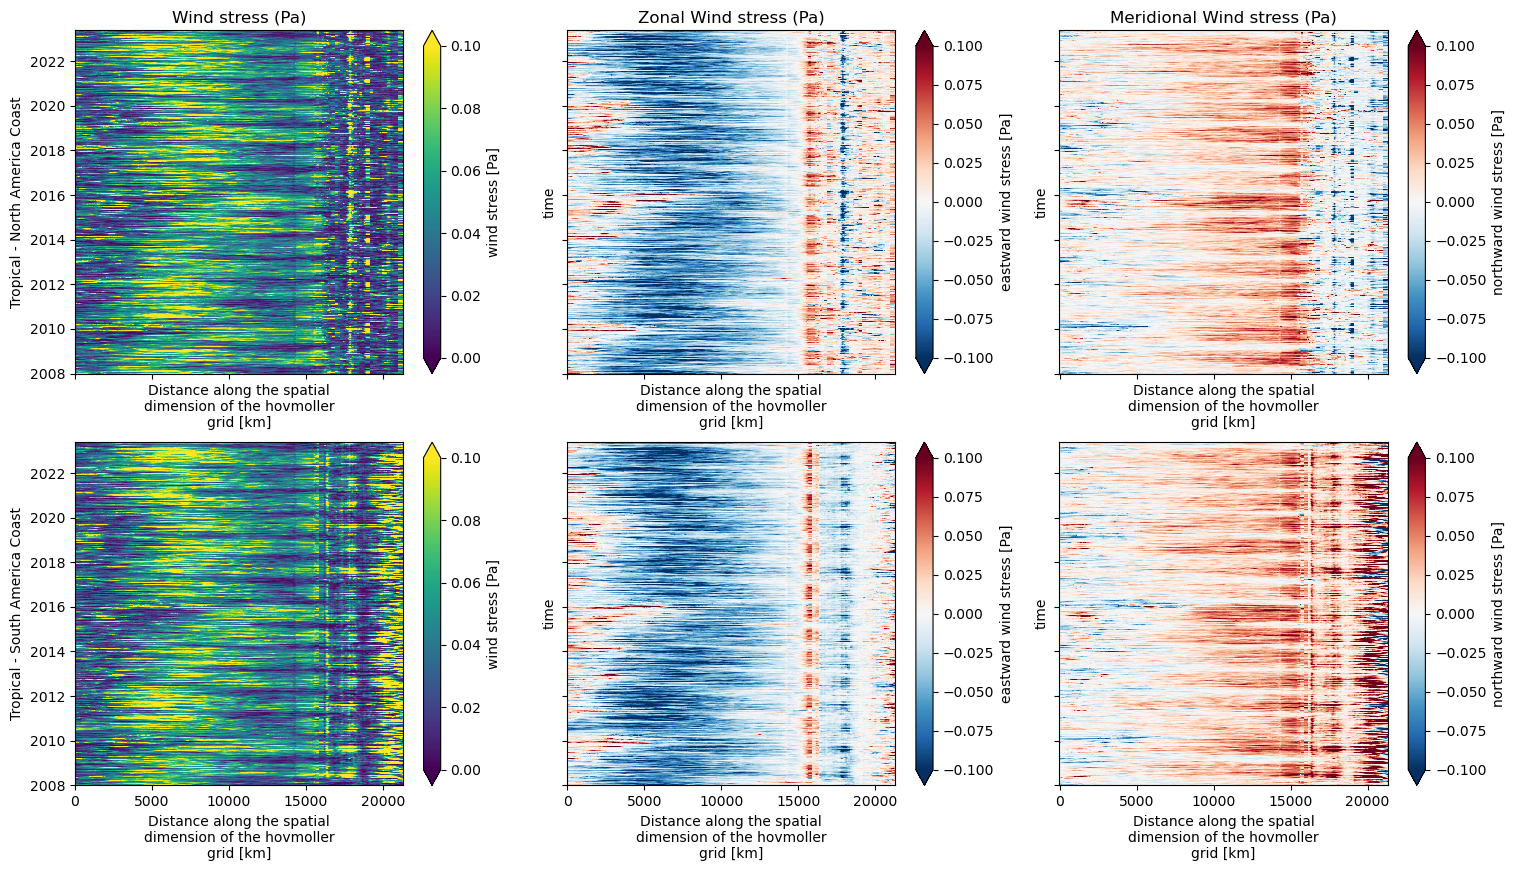

In [164]:
# Quicklook to the hovmollers
fig, ax = plt.subplots(2,3, figsize=(18,10), dpi=100, facecolor='w',
                       sharex=True, sharey=True)

xr.concat([tropical,coastnorth], 'distance').tau.plot(ax=ax[0,0], vmin=0, vmax=0.1, cmap='viridis')
xr.concat([tropical,coastnorth], 'distance').taux.plot(ax=ax[0,1], vmin=-0.1,vmax=0.1, cmap='RdBu_r')
xr.concat([tropical,coastnorth], 'distance').tauy.plot(ax=ax[0,2], vmin=-0.1,vmax=0.1, cmap='RdBu_r')

xr.concat([tropical,coastsouth], 'distance').tau.plot(ax=ax[1,0], vmin=0, vmax=0.1, cmap='viridis')
xr.concat([tropical,coastsouth], 'distance').taux.plot(ax=ax[1,1], vmin=-0.1,vmax=0.1, cmap='RdBu_r')
xr.concat([tropical,coastsouth], 'distance').tauy.plot(ax=ax[1,2], vmin=-0.1,vmax=0.1, cmap='RdBu_r')

ax[0,0].set_title('Wind stress (Pa)')
ax[0,1].set_title('Zonal Wind stress (Pa)')
ax[0,2].set_title('Meridional Wind stress (Pa)')

ax[0,0].set_ylabel('Tropical - North America Coast')
ax[1,0].set_ylabel('Tropical - South America Coast')